# Running Hugging Face Text Generation Inference (TGI) with Llama-3.1 8B

Hugging Face Text Generation Inference (TGI) is a high-performance, low-latency solution for serving advanced language models in production. It streamlines the process of text generation, enabling developers to deploy and scale language models for tasks like conversational AI and content creation.

This tutorial demonstrates how to configure and run TGI using AMD Instinct™ GPUs, leveraging the ROCm software stack for accelerated performance. Learn how to set up your environment, containerize your workflow, and test your inference server by sending customized queries. 

## Prerequisites

This tutorial was developed and tested using the following setup. 

### Operating system

* **Ubuntu 22.04**: Ensure your system is running Ubuntu version 22.04.

### Hardware

* **AMD Instinct GPUs**: This tutorial was tested on an AMD Instinct MI300X GPU. Ensure you are using an AMD Instinct GPU or compatible hardware with ROCm support and that your system meets the [official requirements](https://rocm.docs.amd.com/projects/install-on-linux/en/latest/reference/system-requirements.html).

### Software

* **ROCm 6.2**: Install and verify ROCm by following the [ROCm install guide](https://rocm.docs.amd.com/projects/install-on-linux/en/latest/install/quick-start.html). After installation, confirm your setup using:

    ``` bash
    rocm-smi
    ```

    This command lists your AMD GPU(s) with relevant details, similar to the image below.

   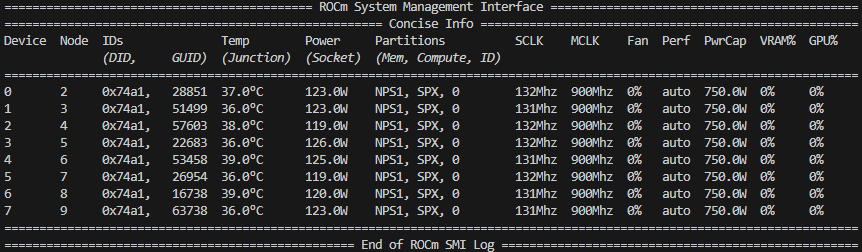


* **Docker**: Ensure Docker is installed and configured correctly. Follow the Docker installation guide for your operating system.

   **Note**: Ensure the Docker permissions are correctly configured. To configure permissions to allow non-root access, run the following commands:

   ``` bash
   sudo usermod -aG docker $USER
   newgrp docker
   ```

   Verify Docker is working correctly:

   ``` bash
   docker run hello-world
   ```

### Hugging Face API access

* Obtain an API token from [Hugging Face](https://huggingface.co) for downloading models.
* Ensure the Hugging Face API token has the necessary permissions and approval to access [Meta's Llama checkpoints](https://huggingface.co/meta-llama/Llama-3.1-8B).


## Prepare the inference environment

### 1. Launch the Docker container

Run the following command in your terminal to pull the prebuilt Docker image containing all necessary dependencies and launch the Docker container with the proper configuration:

``` bash
docker run -it --rm \
  --network=host \
  --device=/dev/kfd \
  --device=/dev/dri \
  --group-add=video \
  --ipc=host \
  --cap-add=SYS_PTRACE \
  --security-opt seccomp=unconfined \
  --shm-size=8G \
  --hostname=ROCm-FT \
  --env HUGGINGFACE_HUB_CACHE=/workspace \
  -v $(pwd):/workspace \
  -w /workspace/notebooks \
  --entrypoint /bin/bash \
  ghcr.io/huggingface/text-generation-inference:latest-rocm
```

**Note**: This command mounts the current directory to the `/workspace` directory in the container. Ensure the notebook file is either copied to this directory before running the Docker command or uploaded into the Jupyter Notebook environment after it starts. Save the token or URL provided in the terminal output to access the notebook from your web browser. You can download this notebook from the [AI Developer Hub GitHub repository](https://github.com/ROCm/gpuaidev-docs).

### 2. Install and launch Jupyter

Inside the Docker container, install Jupyter using the following command:

``` bash
pip install jupyter
```

Then start the Jupyter server:

``` bash
jupyter-lab --ip=0.0.0.0 --port=8888 --no-browser --allow-root
```

**Note**: Ensure port `8888` is not already in use on your system before running the above command. If it is, you can specify a different port by replacing `--port=8888` with another port number, for example, `--port=8890`.


### 3. Provide your Hugging Face token

You'll require a Hugging Face API token to access meta-llama/Llama-3.1-8B-Instruct. Generate your token at Hugging Face Tokens and request access for [meta-llama/Llama-3.1-8B-Instruct](https://huggingface.co/meta-llama/Llama-3.1-8B-Instruct). Tokens typically start with "hf_". 

Run the following interactive block in your Jupyter notebook to set up the token:

**Note**: Uncheck the "Add token as Git credential?" option.

In [ ]:
from huggingface_hub import notebook_login, HfApi

# Prompt the user to log in
notebook_login()

Verify that your token was accepted correctly:

In [ ]:
# Validate the token
try:
    api = HfApi()
    user_info = api.whoami()
    print(f"Token validated successfully! Logged in as: {user_info['name']}")
except Exception as e:
    print(f"Token validation failed. Error: {e}")

## Deploying the LLM using Hugging Face TGI

Start deploying the LLM (meta-llama/Llama-3.1-8B-Instruct) using Hugging Face TGI in the Jupyter notebook.

### Start the text generator server 

Run this command to launch the TGI Text Generator Launcher:

In [ ]:
!HIP_VISIBLE_DEVICES=4 \
text-generation-launcher \
    --model-id meta-llama/Llama-3.1-8B-Instruct \
    --num-shard 1 \
    --cuda-graphs 1 \
    --max-batch-prefill-tokens 131072 \
    --max-batch-total-tokens 139264 \
    --dtype float16 \
    --port 8000 \
    --trust-remote-code

**Note**: In a multi-GPU environment, the setting `HIP_VISIBLE_DEVICES=x` is recommended to deploy the LLM on your preferred GPU.

### Start the client

After successfully running the server, as described above, open a new notebook and send a query to the server as shown below.

**Note**: For this step, a new Python notebook must be opened. After the notebook cell is created, copy the code below and run it in your new notebook. New notebooks can be opened by selecting **File->New->Notebook**. 

In [ ]:
import requests
import json

url = "http://localhost:8000/generate"
headers = {
    "Content-Type": "application/json"
}
data = {
    "inputs": "System: You are an expert in the field of AI. Make sure to provide an explanation in few sentences.\nUser: Explain the concept of AI.\nAssistant:",
    "parameters": {
        "max_new_tokens": 128,
        "do_sample": False
    }
}

response = requests.post(url, headers=headers, json=data)
print(response.json())

**Note**: Remember to match the Docker `--port` **8000** and the port indicated in the URL, for instance, http://localhost:**8000**. If the port is already used by another application, you can modify the number. 

If the connection is successful, the output will be:

``` bash
{"generated_text":" AI, or Artificial Intelligence, refers to the development of computer systems that can perform tasks that typically require human intelligence, such as learning, problem-solving, ...}
```